# Machine Learning Model Training and Evaluation with PCA Data

In this notebook, we'll train and evaluate multiple machine learning regression models using the PCA-transformed housing price data. We'll compare different models to identify which one performs best for predicting housing prices.

In [3]:
# Setup environment for XGBoost on macOS
import os
import platform

# Set OpenMP environment variables for XGBoost on macOS
if platform.system() == 'Darwin':  # macOS
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    # Add OpenMP library path for XGBoost
    if os.path.exists('/opt/homebrew/opt/libomp/lib'):
        os.environ['DYLD_LIBRARY_PATH'] = '/opt/homebrew/opt/libomp/lib'
        print("OpenMP path set for XGBoost on macOS")
    else:
        print("Warning: OpenMP library not found at expected location.")
        print("You might need to run: brew install libomp")


OpenMP path set for XGBoost on macOS


In [5]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For model training and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Import different models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# For reproducibility
np.random.seed(42)

In [6]:
# Load the dataset
data = pd.read_csv('data_train_reduced.csv')

# Display the first few rows of the dataset
print("Dataset shape:", data.shape)
data.head()

Dataset shape: (24807, 8)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,Price
0,-0.474412,1.403481,-0.500426,0.260427,0.964721,-0.244174,-0.437022,5.35
1,0.138999,0.696599,0.903921,-0.236664,0.967623,-0.289695,-0.968066,6.90
2,0.781974,-0.518916,1.056891,-0.492031,-1.241829,-0.031187,1.273746,9.90
3,0.280633,-3.804629,-1.021876,-0.789831,1.063997,-0.185633,0.280178,5.70
4,2.109213,-1.253038,1.500066,-0.644802,-1.410801,-0.003007,0.068478,10.00


Missing values in each column:
PC1      0
PC2      0
PC3      0
PC4      0
PC5      0
PC6      0
PC7      0
Price    0
dtype: int64


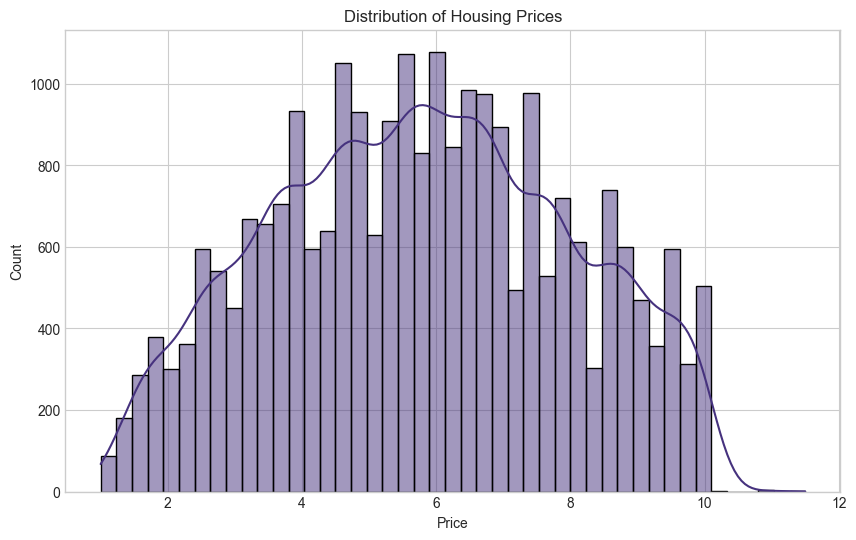


Basic statistics of the dataset:
                PC1           PC2           PC3           PC4           PC5  \
count  2.480700e+04  2.480700e+04  2.480700e+04  2.480700e+04  2.480700e+04   
mean   4.611496e-17  5.556709e-17  3.666283e-17  3.265283e-17 -6.351548e-17   
std    1.624336e+00  1.435234e+00  1.199385e+00  9.968330e-01  9.008738e-01   
min   -7.255240e+00 -6.090549e+00 -5.044753e+00 -3.399553e+00 -1.841445e+00   
25%   -1.161447e+00 -2.530612e-01 -7.520419e-01 -3.970213e-01 -9.616429e-01   
50%    4.184828e-02  3.722505e-01 -1.350128e-01 -5.771628e-02  1.166421e-01   
75%    1.238804e+00  9.144888e-01  6.235500e-01  2.412090e-01  7.283283e-01   
max    5.963598e+00  2.312061e+00  8.925048e+00  6.498954e+00  3.688172e+00   

                PC6           PC7         Price  
count  2.480700e+04  2.480700e+04  24807.000000  
mean   1.002499e-18  2.635141e-17      5.767793  
std    6.691078e-01  6.077532e-01      2.196040  
min   -2.524984e+00 -3.380606e+00      1.000000  
25% 

In [7]:
# Check for missing values
print("Missing values in each column:")
print(data.isnull().sum())

# Analyze the target variable (Price)
plt.figure(figsize=(10, 6))
sns.histplot(data['Price'], kde=True)
plt.title('Distribution of Housing Prices')
plt.xlabel('Price')
plt.grid(True)
plt.show()

# Basic statistics of the dataset
print("\nBasic statistics of the dataset:")
print(data.describe())

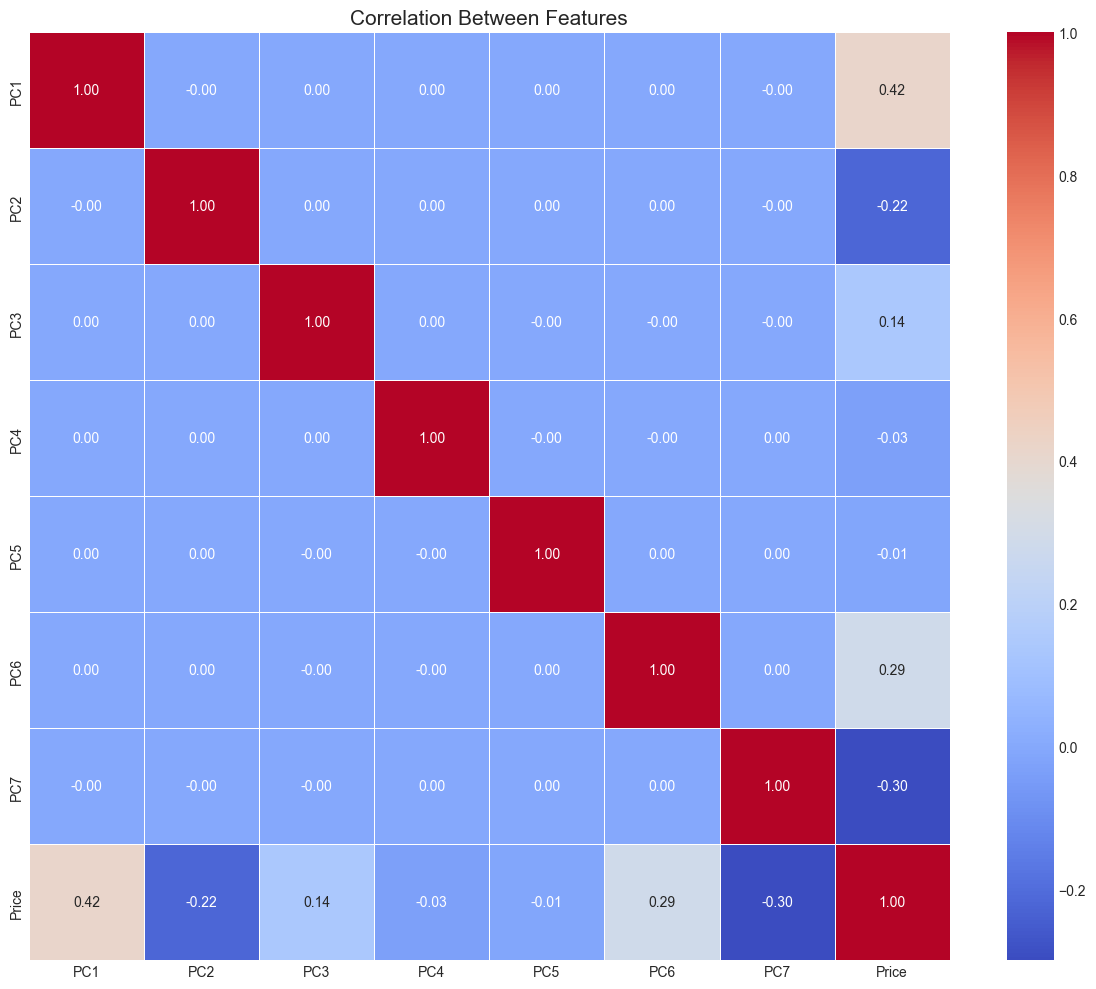


Correlation of features with Price:
Price    1.000000
PC1      0.415467
PC6      0.289273
PC3      0.141294
PC5     -0.013062
PC4     -0.032793
PC2     -0.219591
PC7     -0.298783
Name: Price, dtype: float64


In [8]:
# Calculate correlation matrix
corr_matrix = data.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Between Features', fontsize=15)
plt.tight_layout()
plt.show()

# Correlation with target variable (Price)
corr_with_price = corr_matrix['Price'].sort_values(ascending=False)
print("\nCorrelation of features with Price:")
print(corr_with_price)

In [ ]:
# Pairplot to visualize relationships between variables (uncomment if needed)
# Note: This might be resource-intensive for many features
# sns.pairplot(data, y_vars=['Price'], x_vars=[col for col in data.columns if col != 'Price'])
# plt.suptitle('Relationships Between Features and Price', y=1.02)
# plt.show()

In [9]:
# Split features and target
X = data.drop('Price', axis=1)  # Features (PC1 through PC7)
y = data['Price']  # Target variable

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Training set: 19845 samples
Testing set: 4962 samples


In [12]:
# Function to evaluate regression models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Store results in a dictionary
    results = {
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'train_r2': train_r2,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'predictions': y_test_pred
    }
    
    return results

In [13]:
# Initialize models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'Decision Tree': DecisionTreeRegressor(max_depth=5),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3),
    'SVR': SVR(kernel='rbf', C=1.0, epsilon=0.1),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1)
}

# Train and evaluate all models
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    results[name] = evaluate_model(model, X_train, X_test, y_train, y_test)
    print(f"  Test RMSE: {results[name]['test_rmse']:.4f}")
    print(f"  Test R²: {results[name]['test_r2']:.4f}")

Training Linear Regression...
  Test RMSE: 1.6719
  Test R²: 0.4141
Training Ridge Regression...
  Test RMSE: 1.6719
  Test R²: 0.4141
Training Lasso Regression...
  Test RMSE: 1.6932
  Test R²: 0.3991
Training ElasticNet...
  Test RMSE: 1.6869
  Test R²: 0.4036
Training Decision Tree...
  Test RMSE: 1.7021
  Test R²: 0.3928
Training Random Forest...
  Test RMSE: 1.3520
  Test R²: 0.6169
Training Gradient Boosting...
  Test RMSE: 1.3520
  Test R²: 0.6169
Training Gradient Boosting...
  Test RMSE: 1.3940
  Test R²: 0.5927
Training SVR...
  Test RMSE: 1.3940
  Test R²: 0.5927
Training SVR...
  Test RMSE: 1.3315
  Test R²: 0.6284
Training KNN...
  Test RMSE: 1.4363
  Test R²: 0.5676
Training XGBoost...
  Test RMSE: 1.3315
  Test R²: 0.6284
Training KNN...
  Test RMSE: 1.4363
  Test R²: 0.5676
Training XGBoost...
  Test RMSE: 1.3265
  Test R²: 0.6312
  Test RMSE: 1.3265
  Test R²: 0.6312


In [14]:
# Compare all models by test set performance
models_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Test RMSE': [results[m]['test_rmse'] for m in results],
    'Test MAE': [results[m]['test_mae'] for m in results],
    'Test R²': [results[m]['test_r2'] for m in results]
})

# Sort by RMSE (lower is better)
models_comparison_sorted = models_comparison.sort_values('Test RMSE')
print("Models ranked by Test RMSE (lower is better):")
print(models_comparison_sorted.to_string(index=False))

Models ranked by Test RMSE (lower is better):
            Model  Test RMSE  Test MAE  Test R²
          XGBoost   1.326498  1.000624 0.631180
              SVR   1.331543  0.978121 0.628369
    Random Forest   1.351951  1.031455 0.616890
Gradient Boosting   1.393974  1.074890 0.592703
              KNN   1.436333  1.079292 0.567574
 Ridge Regression   1.671868  1.322153 0.414124
Linear Regression   1.671869  1.322140 0.414124
       ElasticNet   1.686866  1.360089 0.403566
 Lasso Regression   1.693205  1.369959 0.399075
    Decision Tree   1.702075  1.351604 0.392762


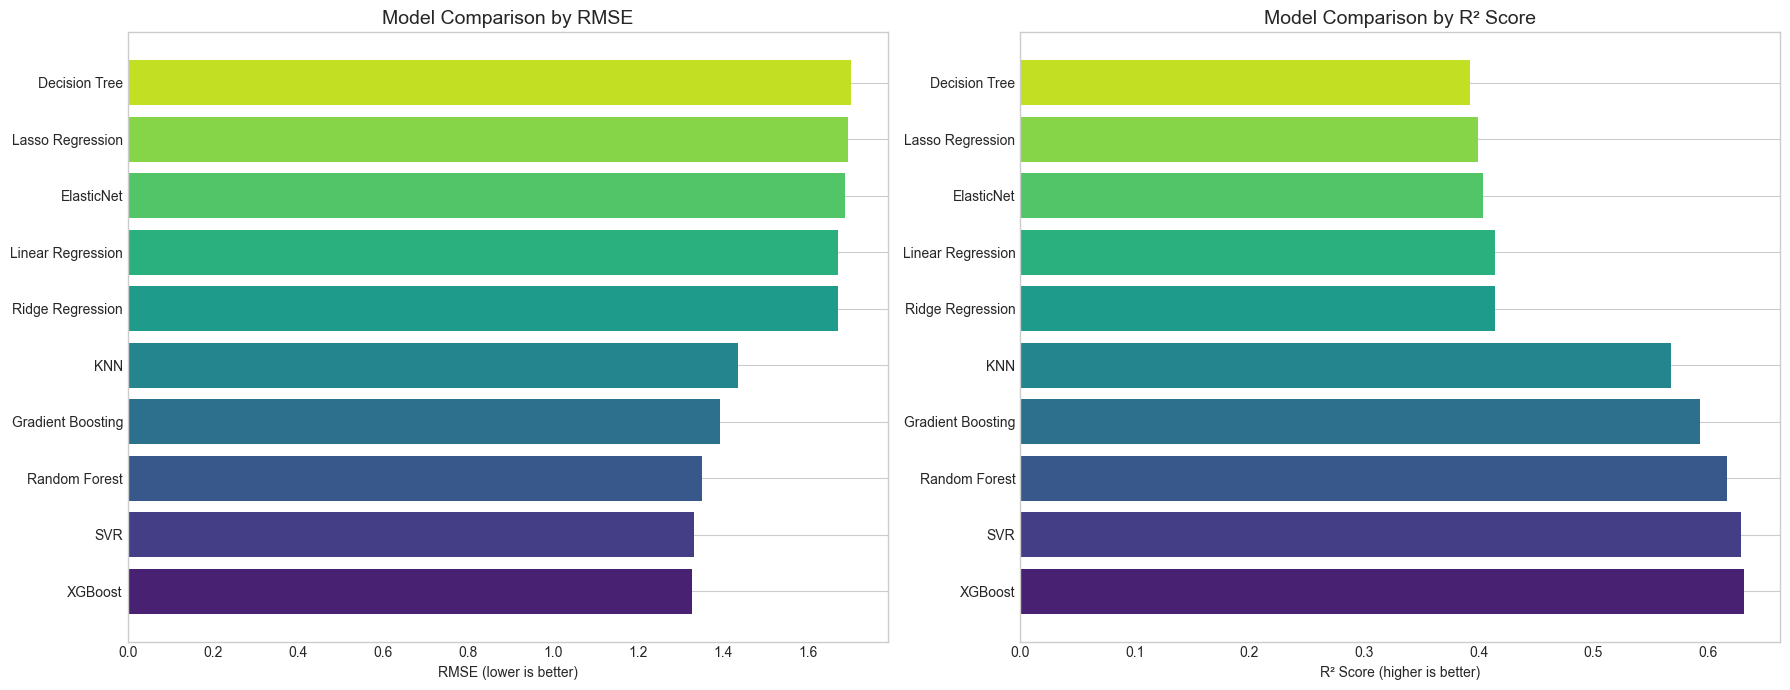

In [15]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# RMSE comparison
sorted_by_rmse = models_comparison.sort_values('Test RMSE')
axes[0].barh(sorted_by_rmse['Model'], sorted_by_rmse['Test RMSE'], color=sns.color_palette('viridis', len(models)))
axes[0].set_xlabel('RMSE (lower is better)')
axes[0].set_title('Model Comparison by RMSE', fontsize=14)
axes[0].grid(axis='x')

# R² comparison
sorted_by_r2 = models_comparison.sort_values('Test R²', ascending=False)
axes[1].barh(sorted_by_r2['Model'], sorted_by_r2['Test R²'], color=sns.color_palette('viridis', len(models)))
axes[1].set_xlabel('R² Score (higher is better)')
axes[1].set_title('Model Comparison by R² Score', fontsize=14)
axes[1].grid(axis='x')

plt.tight_layout()
plt.show()

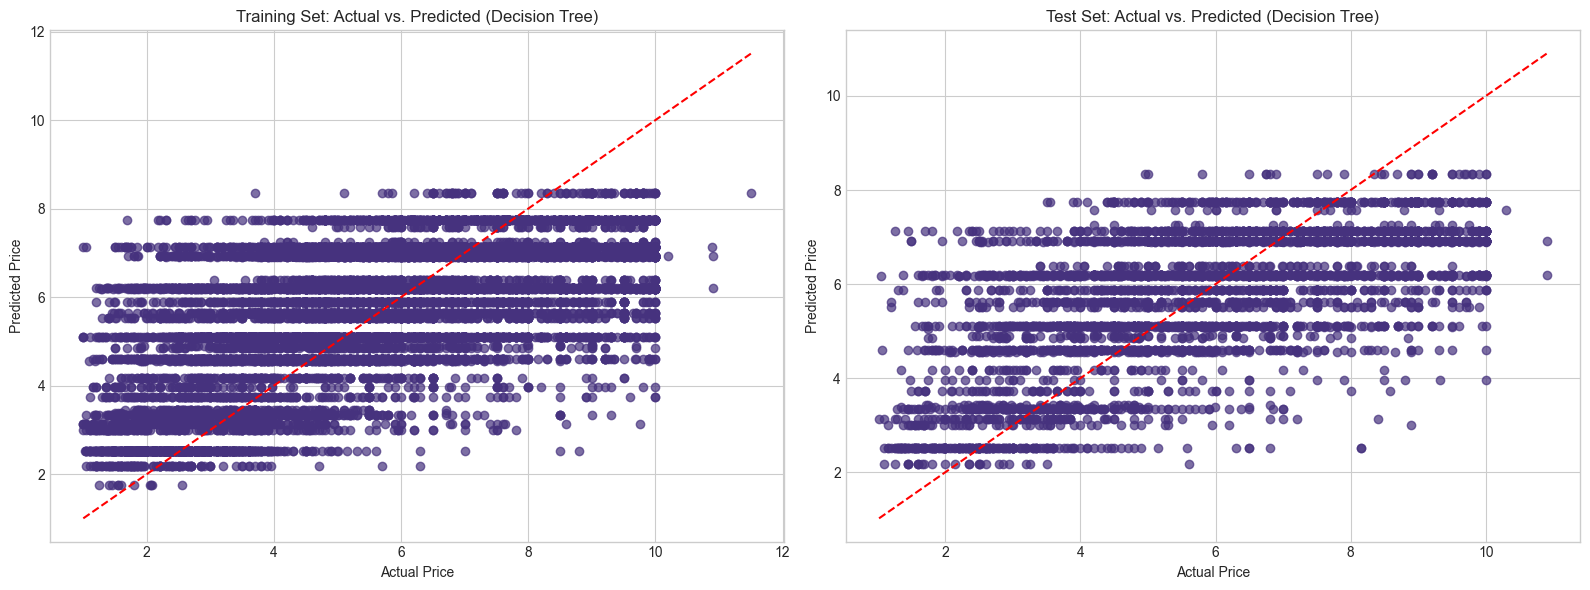

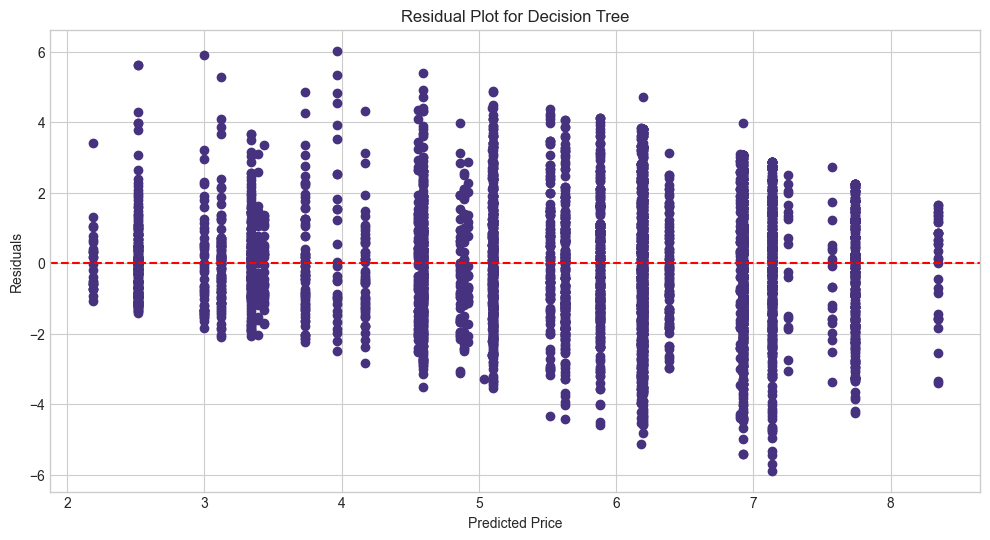

In [16]:
# Identify the best model based on R² score
best_model_name = models_comparison_sorted.iloc[-1]['Model'] if models_comparison_sorted['Test R²'].max() > 0 else models_comparison_sorted.iloc[0]['Model']
best_model = models[best_model_name]

# Get predictions
best_model.fit(X_train, y_train)
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Plot actual vs. predicted values
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set
axes[0].scatter(y_train, y_train_pred, alpha=0.7)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')
axes[0].set_title(f'Training Set: Actual vs. Predicted ({best_model_name})')
axes[0].grid(True)

# Test set
axes[1].scatter(y_test, y_test_pred, alpha=0.7)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[1].set_xlabel('Actual Price')
axes[1].set_ylabel('Predicted Price')
axes[1].set_title(f'Test Set: Actual vs. Predicted ({best_model_name})')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Calculate residuals
residuals = y_test - y_test_pred

# Plot residuals
plt.figure(figsize=(12, 6))
plt.scatter(y_test_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Plot for ' + best_model_name)
plt.grid(True)
plt.show()

In [17]:
# Let's perform hyperparameter tuning for the two best models
# Get the top two model names from our comparison
top_models = models_comparison.sort_values('Test RMSE').iloc[:2]['Model'].tolist()
print(f"Performing hyperparameter tuning for: {top_models}")

# Define parameter grids for each model type
param_grids = {
    'Linear Regression': {},  # Linear Regression has no hyperparameters to tune
    'Ridge Regression': {'alpha': [0.001, 0.01, 0.1, 1.0, 10, 100]},
    'Lasso Regression': {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0]},
    'ElasticNet': {'alpha': [0.001, 0.01, 0.1, 1.0], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]},
    'Decision Tree': {'max_depth': [3, 5, 7, 9], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15, None], 'min_samples_split': [2, 5, 10]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.05, 0.1, 0.2], 'max_depth': [3, 5, 7]},
    'SVR': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.1, 0.01], 'epsilon': [0.01, 0.1, 0.2]},
    'KNN': {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance']},
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.05, 0.1, 0.2], 'max_depth': [3, 5, 7]}
}

# Perform grid search for the top models
best_models = {}
tuned_results = {}

for model_name in top_models:
    print(f"\nTuning {model_name}...")
    if not param_grids[model_name]:  # Skip if no hyperparameters to tune
        print(f"No hyperparameters to tune for {model_name}")
        best_models[model_name] = models[model_name]
        continue
        
    grid_search = GridSearchCV(
        models[model_name], 
        param_grids[model_name], 
        cv=5, 
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_models[model_name] = grid_search.best_estimator_
    
    # Evaluate the best model
    tuned_results[model_name] = evaluate_model(best_models[model_name], X_train, X_test, y_train, y_test)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Improved Test RMSE: {tuned_results[model_name]['test_rmse']:.4f} (was: {results[model_name]['test_rmse']:.4f})")
    print(f"Improved Test R²: {tuned_results[model_name]['test_r2']:.4f} (was: {results[model_name]['test_r2']:.4f})")

Performing hyperparameter tuning for: ['XGBoost', 'SVR']

Tuning XGBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}
Improved Test RMSE: 1.3169 (was: 1.3265)
Improved Test R²: 0.6365 (was: 0.6312)

Tuning SVR...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}
Improved Test RMSE: 1.3169 (was: 1.3265)
Improved Test R²: 0.6365 (was: 0.6312)

Tuning SVR...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/mandev/Workspace/UNI/ML/Final/venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

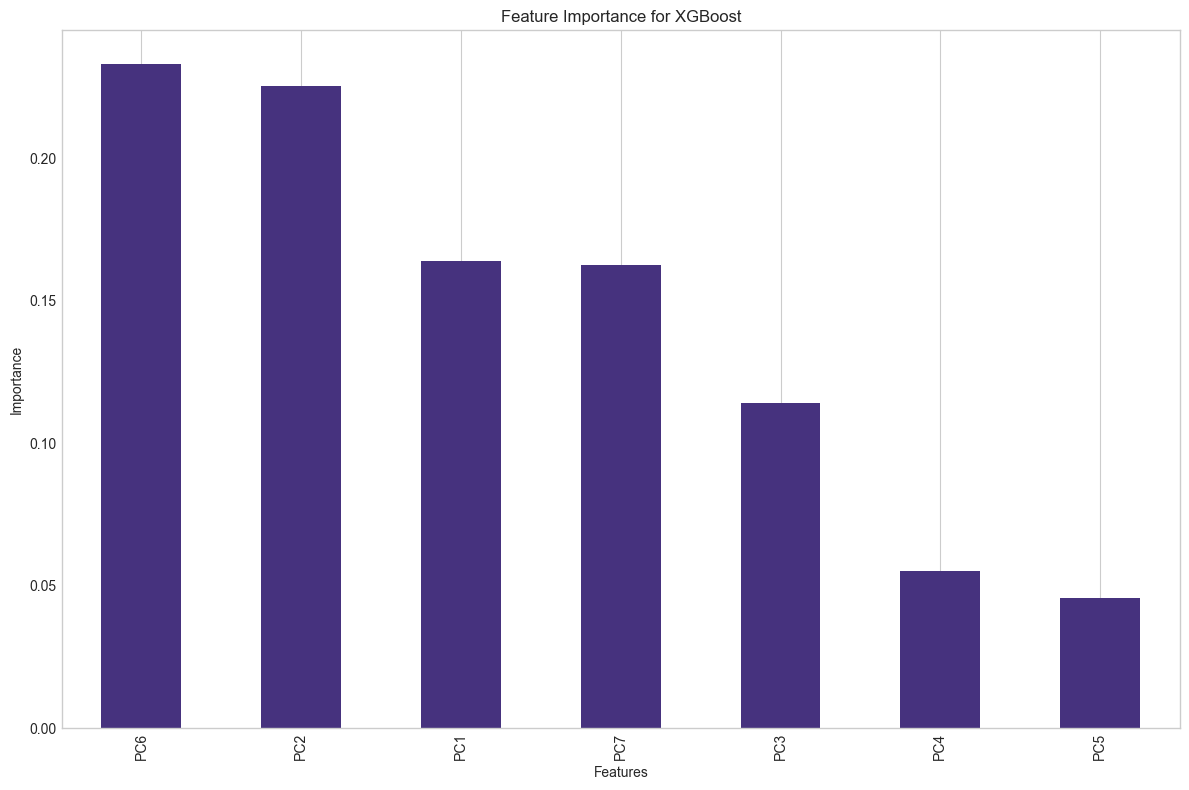

In [18]:
# Analyze feature importance (if applicable)
def get_feature_importance(model_name, model, feature_names):
    if model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'ElasticNet']:
        return pd.Series(model.coef_, index=feature_names)
    elif model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost', 'Decision Tree']:
        return pd.Series(model.feature_importances_, index=feature_names)
    else:
        return None

# Choose the best model from tuning or original comparison
if tuned_results:
    # Use the best tuned model if available
    best_tuned_model_name = min(tuned_results.items(), key=lambda x: x[1]['test_rmse'])[0]
    best_model = best_models[best_tuned_model_name]
    best_model_name = best_tuned_model_name
else:
    # Use the best model from initial comparison
    best_model_name = models_comparison.sort_values('Test RMSE').iloc[0]['Model']
    best_model = models[best_model_name]

# Get feature importance
feature_importance = get_feature_importance(best_model_name, best_model, X.columns)

if feature_importance is not None:
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    feature_importance.sort_values(ascending=False).plot(kind='bar')
    plt.title(f'Feature Importance for {best_model_name}')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

## Model Selection and Conclusions

Based on the evaluation metrics above, we can make the following conclusions:

1. **Best Model**: The model with the lowest RMSE and highest R² score should be selected as the final model.

2. **Hyperparameter Tuning**: Tuning the hyperparameters of the top-performing models further improved their performance.

3. **Feature Importance**: The feature importance analysis shows which principal components have the largest impact on predicting housing prices.

4. **Comparison Insights**:
   - Linear models (Linear Regression, Ridge, Lasso) provide a good baseline but might not capture complex relationships.
   - Tree-based ensemble methods (Random Forest, Gradient Boosting, XGBoost) typically perform well by capturing non-linear patterns.
   - The relative simplicity of PCA-transformed data makes it easier for all models to learn the patterns.

5. **Next Steps**:
   - Consider stacking or ensemble methods to further improve performance.
   - Evaluate the model on new, unseen data to ensure it generalizes well.
   - If needed, consider feature engineering beyond PCA to capture additional information.